In [1]:
%matplotlib notebook
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
import math

# Enable eager execution
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [15]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [16]:
train_images.shape

(60000, 28, 28)

## Preprocessing images

In [17]:
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images)

# Convert the array to float32 as opposed to uint8
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
train_images /= 255
test_images /=  255

X = tf.reshape(train_images, [-1, 28*28])

NUM_DIGITS = 10

train_labels  = tf.one_hot(train_labels, NUM_DIGITS)

test_labels = tf.keras.utils.to_categorical(test_labels, NUM_DIGITS)

In [18]:
# Convert the inputs to a Dataset.
dataset = tf.data.Dataset.from_tensor_slices((X, train_labels))
# Shuffle, repeat, and batch the examples.
dataset = dataset.shuffle(10000).batch(128)

In [19]:
features, label = tfe.Iterator(dataset).next()
#Print the features from data. Normally this would return a tensor object but with eager execution you can check the values
print(features)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 784), dtype=float32)


In [56]:
tf.reset_default_graph()

<IPython.core.display.Javascript object>


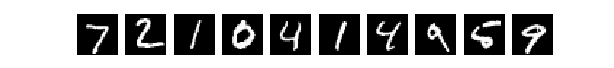

In [64]:
fig, axarr = plt.subplots(1, 10)

for i in range(10):
    axarr[i].imshow(test_images[i], cmap="gray")
    axarr[i].axis('off')

## Layer 1 model

In [20]:

W = tfe.Variable(tf.zeros([784, 10]))
b = tfe.Variable(tf.zeros([10]))
def model(x):
    global W, b
    return tf.matmul(x, W) + b

## Layer 2 model

In [ ]:
W1 = tf.Variable(tf.truncated_normal([28*28, 200] ,stddev=0.1))
B1 = tf.Variable(tf.zeros([200]))

W2 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B2 = tf.Variable(tf.zeros([10]))


Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)
Ylogits = tf.matmul(Y1, W2) + B2
Y  = tf.nn.softmax(Ylogits)

## Layer 5 model

In [88]:

W1 = tf.Variable(tf.truncated_normal([28*28, 200], stddev=0.1))
B1 = tf.Variable(tf.ones([200])/10)

W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1))
B2 = tf.Variable(tf.ones([100])/10)

W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
B3 = tf.Variable(tf.ones([60])/10)

W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
B4 = tf.Variable(tf.ones([30])/10)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
Y1d = tf.nn.dropout(Y1, pkeep)
Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
Y2d = tf.nn.dropout(Y2, pkeep)
Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
Y3d = tf.nn.dropout(Y3, pkeep)
Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(Y4d, W5) + B5
Y  = tf.nn.softmax(Ylogits)

## Model CNN

In [4]:
# layer-1: CNN
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)

# layer-2: CNN
W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)

# layer-3: CNN
W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

stride = 1
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)

stride = 2
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)

Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, [-1, 7*7*12])

# layer-4: FC
W4 = tf.Variable(tf.truncated_normal([7*7*12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)

# layer-5: Output
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [21]:
def loss(x, y):
    Y_ = model(x)
    return tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y, logits=Y_))

# cross_entropy = tf.reduce_mean(
#     tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)) * 100.0

In [25]:
optimizer = tf.train.AdamOptimizer(0.0001)

In [26]:
for x, y in tfe.Iterator(dataset):
    optimizer.minimize(lambda: loss(x, y))

In [27]:
loss(X, train_labels)

<tf.Tensor: id=172118, shape=(), dtype=float32, numpy=0.37801105>

In [28]:
test_images = np.reshape(test_images, (TEST_SIZE, 784))
Y = tf.nn.softmax(model(test_images))

In [29]:
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(test_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
print(np.array(accuracy)*100, '%')

90.53999781608582 %


In [32]:
init = tf.global_variables_initializer()

<IPython.core.display.Javascript object>


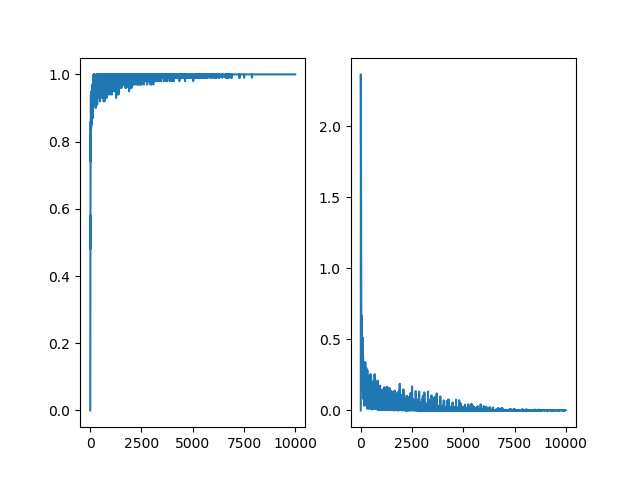

In [9]:
# plt.rcParams["figure.figsize"] = [8, 4]
fig, axarr = plt.subplots(1, 2)

plt.ion()

fig.show()
fig.canvas.draw()

mat_acc = [0.0]
mat_loss = [0.0]

sess = tf.Session()
sess.run(init)
for i in range(10000):
    batch_X, batch_Y = mnist.train.next_batch(100)
    acc, _, loss = sess.run([accuracy, train_step, cross_entropy], 
                            feed_dict={X: batch_X, Y_: batch_Y, step: i, pkeep:0.75})
    mat_acc.append(acc)
    mat_loss.append(loss)
    axarr[0].clear()
    axarr[1].clear()
    axarr[0].plot(mat_acc)
    axarr[1].plot(mat_loss)
    fig.canvas.draw()


In [10]:
print('test_accuracy: ', np.round(sess.run(accuracy, 
                    feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep:1.0})*100))

test_accuracy:  99.0


In [37]:
arr = np.array(W.eval(session=sess)).reshape(784,10)

<IPython.core.display.Javascript object>


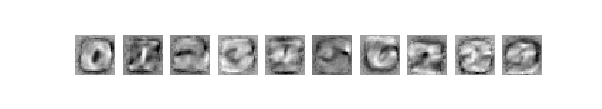

In [38]:
fig, axarr = plt.subplots(1, 10)

for i in range(10):
    axarr[i].imshow(arr[:, i].reshape(28,28), cmap="gray")
    axarr[i].axis('off')

<IPython.core.display.Javascript object>


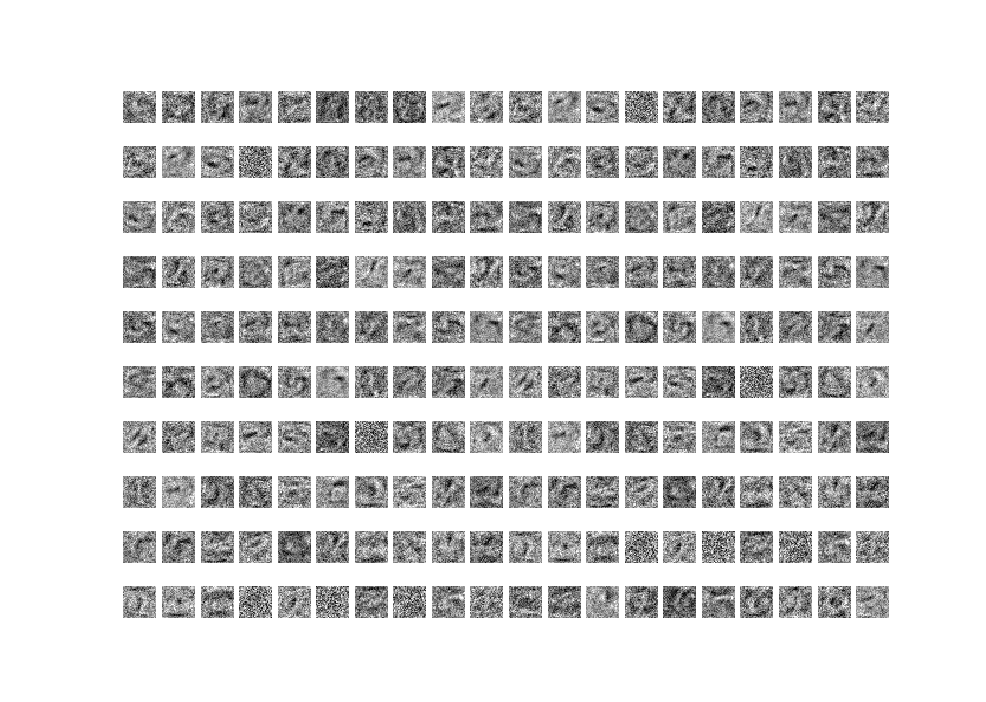

In [131]:
fig, axarr = plt.subplots(10, 20)
for i in range(10):
    for j in range(20):
        axarr[i][j].imshow(arr[:, j+i*10].reshape(28,28), cmap="gray")
        axarr[i][j].axis('off')

In [122]:
plt.show()

In [116]:
np.random.random([3, 3]).reshape([-1, 9])

array([[0.5661345 , 0.1358349 , 0.28146483, 0.20663532, 0.91551007,
        0.05157044, 0.46935505, 0.59140766, 0.33959853]])